In [150]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.fftpack import fft

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import MinMaxScaler

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.utils import to_categorical

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn import metrics

## General variables

In [151]:
category_name = ["ball", "inner_race", "out_race", "normal"]
path_DE = "../../Bearing Vibration Image/data_set_12k_csv/"
path_DE_48K = "../../Bearing Vibration Image/data_set_48k_csv/"
path_FE = "../../Bearing Vibration Image/data_set_12k_FE_csv/"
rpm_DE = "_1796"
rpm_FE = ""

bearing_DE = 0
bearing_FE = 0

DE_config = (rpm_DE, bearing_DE, path_DE) 
DE_config_48k = (rpm_DE, bearing_DE, path_DE_48K) 
FE_config = (rpm_FE, bearing_FE, path_FE)

batch_size = 128
epochs = 20
fft_size = 4056 # 2028 is the equivalent number of samples per 5 rotations at 12kHz, by using scipy fft, the resulting
                # output is the same number
                # In adition this will be the number of features as input for NN
num_classes = 4 # prediction classes
sample_rate = 12000 # Sample rate of data set

## Scale and split

In [152]:
def scale_train_test_split(ffts, return_train_test = True):
    data = ffts[:,:-1]
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)
    data_labels = ffts[:,-1]
    if(return_train_test):       
        x_train, x_test, y_train, y_test = train_test_split(data, data_labels, test_size=0.3)
        return x_train, x_test, y_train, y_test
    else:
        return data,data_labels

## Load data and return the FFT of the sample

In [153]:
def load_data(data_config, datasets, n_fft_size):
    ffts = np.empty((0,n_fft_size + 1))
    for index in datasets:
        for index_name, name in enumerate(category_name):
            no_bearing = data_config[1]
            file_name  = data_config[2] + str(index) + "hp_" + name + data_config[0] + ".csv"
            print(f"Reading from {file_name}")
            data_frame = pd.read_csv(file_name)
            arr = data_frame.iloc[:,no_bearing].values
            max_size = (len(arr)//n_fft_size) * n_fft_size
            for index_size in range(0, max_size, n_fft_size):
                if index == 0:
                    arr_fft = arr[0:n_fft_size]
                else:
                    arr_fft = arr[index_size:index_size + n_fft_size]
                arr_fft = np.array(abs(fft(arr_fft))).reshape(-1, 1).T
                arr_fft = arr_fft[:n_fft_size//2]
                category_column = np.zeros((arr_fft.shape[0], 1), dtype = int) + index_name
                arr_fft = np.hstack((arr_fft,category_column))
                ffts = np.vstack((ffts, arr_fft))
    return ffts

## PCA func

In [154]:
def PCA_sklearn(x,number_components = 2):
    pca = PCA(n_components = number_components)
    principalComponents = pca.fit_transform(x)
    return principalComponents

## MLP scikit

In [155]:
def mlp_sklearn(x, y):
    classifier = MLPClassifier(hidden_layer_sizes=(20,10), max_iter=300, activation = 'relu',solver ='adam',random_state=1)
    classifier.fit(x, y)
    return classifier

## MLP Keras

In [156]:
def mlp_keras(x_train, y_train, x_test, y_test):
    model = Sequential()
    model.add(Dense(20, activation='relu', input_shape=(fft_size,)))
    model.add(Dropout(0.2))
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss = 'categorical_crossentropy', optimizer = RMSprop(), metrics = ['accuracy'])
    history = model.fit(x_train, to_categorical(y_train),batch_size = batch_size, epochs = epochs, verbose = 1,
                        validation_data = (x_test, to_categorical(y_test)))
    return model

## Testing

In [157]:
ffts = load_data(DE_config, [0, 1, 2, 3], fft_size)
print(ffts.shape)

Reading from ../../Bearing Vibration Image/data_set_12k_csv/0hp_ball_1796.csv
Reading from ../../Bearing Vibration Image/data_set_12k_csv/0hp_inner_race_1796.csv
Reading from ../../Bearing Vibration Image/data_set_12k_csv/0hp_out_race_1796.csv
Reading from ../../Bearing Vibration Image/data_set_12k_csv/0hp_normal_1796.csv
Reading from ../../Bearing Vibration Image/data_set_12k_csv/1hp_ball_1796.csv
Reading from ../../Bearing Vibration Image/data_set_12k_csv/1hp_inner_race_1796.csv
Reading from ../../Bearing Vibration Image/data_set_12k_csv/1hp_out_race_1796.csv
Reading from ../../Bearing Vibration Image/data_set_12k_csv/1hp_normal_1796.csv
Reading from ../../Bearing Vibration Image/data_set_12k_csv/2hp_ball_1796.csv
Reading from ../../Bearing Vibration Image/data_set_12k_csv/2hp_inner_race_1796.csv
Reading from ../../Bearing Vibration Image/data_set_12k_csv/2hp_out_race_1796.csv
Reading from ../../Bearing Vibration Image/data_set_12k_csv/2hp_normal_1796.csv
Reading from ../../Bearing V

In [158]:
x_train, x_test, y_train, y_test = scale_train_test_split(ffts)

In [159]:
y_train

array([1., 3., 0., 3., 3., 3., 1., 3., 0., 3., 0., 1., 3., 3., 3., 1., 3.,
       3., 3., 3., 1., 3., 1., 3., 2., 3., 2., 2., 2., 0., 3., 3., 3., 0.,
       3., 3., 1., 1., 0., 3., 1., 2., 3., 3., 1., 3., 3., 1., 1., 3., 2.,
       3., 2., 2., 3., 3., 2., 3., 3., 2., 3., 3., 1., 3., 3., 3., 1., 1.,
       1., 0., 3., 3., 0., 3., 3., 1., 3., 2., 3., 3., 0., 3., 3., 3., 3.,
       3., 3., 0., 2., 3., 0., 3., 1., 3., 3., 3., 3., 3., 0., 3., 3., 3.,
       1., 2., 3., 0., 3., 3., 3., 3., 3., 2., 3., 3., 0., 1., 3., 3., 2.,
       1., 3., 3., 2., 3., 1., 3., 3., 3., 3., 3., 3., 2., 3., 1., 3., 3.,
       0., 3., 3., 3., 3., 0., 2., 0., 3., 3., 0., 2., 0., 0., 3., 3., 0.,
       0., 3., 2., 3., 3., 3., 3., 2., 1., 2., 0., 3., 3., 0., 2., 0., 3.,
       3., 2., 1., 0., 2., 1., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 0.,
       2., 3., 2., 3., 2., 2., 3., 0., 1., 1., 0., 1., 3., 3., 3., 3., 3.,
       2., 1., 3., 3., 1., 0., 1., 3., 3., 1., 0., 1., 3., 1., 3., 1., 2.,
       2., 3., 3., 3., 3.

## PCA

In [160]:
principal_components = PCA_sklearn(x_train)

(85, 2)
(88, 2)
(84, 2)
(286, 2)


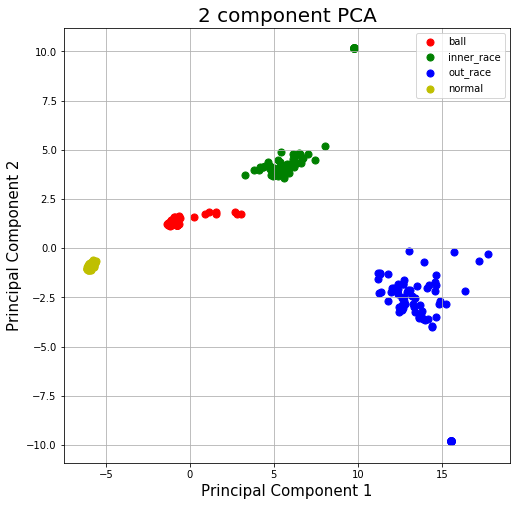

In [161]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = {0: "ball", 1 : "inner_race" , 2 : "out_race", 3 : "normal"}
colors = ['r', 'g', 'b', 'y']

for target, color in zip(targets,colors):
    indicesToKeep = y_train == target
    principal_component_class = principal_components[indicesToKeep]
    print(principal_component_class.shape)
    ax.scatter( principal_component_class[:, 0], 
                principal_component_class[:, 1], 
                c = color,
                s = 50)
ax.legend(targets.values())
ax.grid()

## Testing scikit

In [162]:
classifier = mlp_sklearn(x_train,y_train)

In [163]:
predictions = classifier.predict(x_test)

In [164]:
print(confusion_matrix(y_test, predictions))

[[ 35   0   0   0]
 [  0  31   0   0]
 [  0   0  36   0]
 [  0   0   0 131]]


In [165]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        35
         1.0       1.00      1.00      1.00        31
         2.0       1.00      1.00      1.00        36
         3.0       1.00      1.00      1.00       131

   micro avg       1.00      1.00      1.00       233
   macro avg       1.00      1.00      1.00       233
weighted avg       1.00      1.00      1.00       233



### Validation

In [166]:
ffts_other_load = load_data(FE_config, [0,1,2,3], fft_size)

Reading from ../../Bearing Vibration Image/data_set_12k_FE_csv/0hp_ball.csv
Reading from ../../Bearing Vibration Image/data_set_12k_FE_csv/0hp_inner_race.csv
Reading from ../../Bearing Vibration Image/data_set_12k_FE_csv/0hp_out_race.csv
Reading from ../../Bearing Vibration Image/data_set_12k_FE_csv/0hp_normal.csv
Reading from ../../Bearing Vibration Image/data_set_12k_FE_csv/1hp_ball.csv
Reading from ../../Bearing Vibration Image/data_set_12k_FE_csv/1hp_inner_race.csv
Reading from ../../Bearing Vibration Image/data_set_12k_FE_csv/1hp_out_race.csv
Reading from ../../Bearing Vibration Image/data_set_12k_FE_csv/1hp_normal.csv
Reading from ../../Bearing Vibration Image/data_set_12k_FE_csv/2hp_ball.csv
Reading from ../../Bearing Vibration Image/data_set_12k_FE_csv/2hp_inner_race.csv
Reading from ../../Bearing Vibration Image/data_set_12k_FE_csv/2hp_out_race.csv
Reading from ../../Bearing Vibration Image/data_set_12k_FE_csv/2hp_normal.csv
Reading from ../../Bearing Vibration Image/data_set_

In [167]:
data_test, data_test_labels = scale_train_test_split(ffts_other_load, False)

## PCA on test

In [168]:
principal_components = PCA_sklearn(data_test)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 767 but corresponding boolean dimension is 543

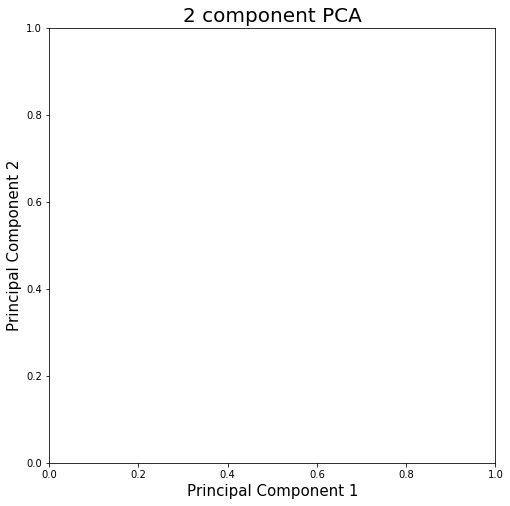

In [169]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = {0: "ball", 1 : "inner_race" , 2 : "out_race", 3 : "normal"}
colors = ['r', 'g', 'b', 'y']

for target, color in zip(targets,colors):
    indicesToKeep = y_train == target
    principal_component_class = principal_components[indicesToKeep]
    print(principal_component_class.shape)
    ax.scatter( principal_component_class[:, 0], 
                principal_component_class[:, 1], 
                c = color,
                s = 50)
ax.legend(targets.values())
ax.grid()

## Predictions

In [170]:
predictions_other_load =  classifier.predict(data_test)

print(np.sum((predictions_other_load == data_test_labels)) / predictions_other_load.shape * 100)

[59.84354628]


In [149]:
print(confusion_matrix(data_test_labels, predictions_other_load))

[[  0   0 237   0]
 [  0   7 229   0]
 [  0   0 237   0]
 [  0   0   0 836]]


In [100]:
print(classification_report(data_test_labels, predictions_other_load))

              precision    recall  f1-score   support

         0.0       0.85      0.05      0.09       237
         1.0       0.55      0.55      0.55       236
         2.0       0.28      0.54      0.37       237
         3.0       1.00      1.00      1.00       836

   micro avg       0.71      0.71      0.71      1546
   macro avg       0.67      0.53      0.50      1546
weighted avg       0.80      0.71      0.69      1546



## Testing Keras

In [72]:
mlp_keras_model = mlp_keras(x_train, y_train, x_test, y_test)

Train on 1088 samples, validate on 467 samples
Epoch 1/20
1088/1088 [==============================] - 0s 144us/step - loss: 0.8140 - accuracy: 0.7381 - val_loss: 0.3087 - val_accuracy: 1.0000
Epoch 2/20
1088/1088 [==============================] - 0s 43us/step - loss: 0.3455 - accuracy: 0.9035 - val_loss: 0.1501 - val_accuracy: 1.0000
Epoch 3/20
1088/1088 [==============================] - 0s 43us/step - loss: 0.2436 - accuracy: 0.9292 - val_loss: 0.0824 - val_accuracy: 1.0000
Epoch 4/20
1088/1088 [==============================] - 0s 43us/step - loss: 0.1823 - accuracy: 0.9513 - val_loss: 0.0488 - val_accuracy: 1.0000
Epoch 5/20
1088/1088 [==============================] - 0s 43us/step - loss: 0.1320 - accuracy: 0.9733 - val_loss: 0.0236 - val_accuracy: 1.0000
Epoch 6/20
1088/1088 [==============================] - 0s 43us/step - loss: 0.1033 - accuracy: 0.9706 - val_loss: 0.0143 - val_accuracy: 1.0000
Epoch 7/20
1088/1088 [==============================] - 0s 43us/step - loss: 0.074

In [73]:
mlp_keras_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 20)                40580     
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 20)                420       
_________________________________________________________________
dropout_4 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 84        
Total params: 41,084
Trainable params: 41,084
Non-trainable params: 0
_________________________________________________________________


In [74]:
score = mlp_keras_model.evaluate(data_test, to_categorical(data_test_labels), verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 7.425635376304292e-05
Test accuracy: 1.0


In [75]:
predictions_keras_mlp = mlp_keras_model.predict_classes(data_test)

In [76]:
print(confusion_matrix(data_test_labels, predictions_keras_mlp))

[[240   0   0   0]
 [  0 239   0   0]
 [  0   0 240   0]
 [  0   0   0 836]]
